# Practical Work - Implicit Q-Learning

<div class="alert alert-info">

...

<br>

...

<br>

...

</div>

### Imports and auxiliary settings

In [1]:
!apt update
!pip install swig
!pip install gym gym[box2d]
!pip install stable-baselines3[extra]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [783 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,081 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,641 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:13 https://ppa.launch

In [25]:
import gym
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from tqdm import tqdm

import warnings

# Suppress specific DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message="np.find_common_type is deprecated")

# Seeds for Reproducability

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
SEED = 123456

# Call this function at the beginning of the script
set_seed(seed=SEED)

# Setup Google Drive mount to store your results

In [5]:
use_google_drive = True
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection with Online RL

In [6]:
# Function to save dataset to a file
def save_dataset(dataset, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# Function to load dataset
def load_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Create Enviornment

In [7]:
# Create and wrap the environment
env_id = 'LunarLanderContinuous-v2'
env = make_vec_env(env_id, n_envs=1, seed=SEED)

## 1. Random Dataset

In [8]:
def generate_random_dataset(env, seed, num_episodes=1000):
    tqdm.write('Generating Random Dataset...')
    random_dataset = []

    # Set the seed for the environment and the random number generator
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    for _ in tqdm(range(num_episodes), desc='Random policy steps'):
        obs = env.reset()
        done = [False]

        while not done[0]:
            # Sample an action from the action space of the environment
            action = [env.action_space.sample()]
            # Step through the environment with the action
            new_obs, reward, done, _ = env.step(action)
            # Append the experience to the dataset
            random_dataset.append((obs[0], action[0], reward[0], new_obs[0], done[0]))
            obs = new_obs

    return random_dataset

In [9]:
# Generate Random Dataset
random_dataset = generate_random_dataset(env=env, seed=SEED, num_episodes=1000)


# Print out a few samples from the dataset to verify reproducibility
#print("Sample entries from the generated dataset:")
#for i, sample in enumerate(random_dataset[:5]):
#    print(f"Entry {i}: {sample}")

# Save the Dataset
save_dataset(random_dataset, 'Random_dataset.pkl')

# Move dataset to Google Drive (if using Colab)
!cp Random_dataset.pkl /content/drive/MyDrive/Master-AI/Practical-Work

tqdm.write('Random_dataset.pkl saved.')

Generating Random Dataset...


Random policy steps: 100%|██████████| 1000/1000 [00:58<00:00, 17.10it/s]


Random_dataset.pkl saved.


## 2. Expert Dataset

In [10]:
def generate_expert_dataset(env, seed, model, num_episodes=100):
    tqdm.write('Generating Expert Dataset...')
    expert_dataset = []

    # Set the seed for the environment and the random number generator
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    for _ in tqdm(range(num_episodes), desc='Expert policy steps'):
        obs = env.reset()
        done = False

        # Set the seed for the environment and the random number generator
        env.seed(seed)

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            new_obs, reward, done, info = env.step(action)
            # Remove the additional dimension
            expert_dataset.append((obs[0], action[0], reward[0], new_obs[0], done[0]))
            obs = new_obs

    return expert_dataset

In [11]:
# Train a model (PPO or DDPG) to convergence
expert_model = PPO("MlpPolicy", env, verbose=0, seed=SEED)
expert_model.learn(total_timesteps=200000, progress_bar=True)  # Increase timesteps as needed for convergence

# Generate Expert Dataset
expert_dataset = generate_expert_dataset(env=env, seed=SEED, model=expert_model, num_episodes=200)


# Print out a few samples from the dataset to verify content
#print("Sample entries from the generated expert dataset:")
#for i, sample in enumerate(expert_dataset[:5]):
#    print(f"Entry {i}: {sample}")

# Save the Dataset
save_dataset(expert_dataset, 'Expert_dataset.pkl')

# Move dataset to Google Drive (if using Colab)
!cp Expert_dataset.pkl /content/drive/MyDrive/Master-AI/Practical-Work

tqdm.write('Expert_dataset.pkl saved.')

Output()

Generating Expert Dataset...


Expert policy steps: 100%|██████████| 200/200 [08:27<00:00,  2.54s/it]


Expert_dataset.pkl saved.


## 3. Mixed Dataset

In [12]:
def generate_mixed_dataset(seed, random_dataset, expert_dataset):
    tqdm.write('Generating Mixed Dataset...')

    # Set the seed for the environment and the random number generator
    np.random.seed(seed)
    random.seed(seed)

    # Mix datasets: 80% random and 20% expert
    mixed_dataset = random.sample(random_dataset, int(0.8 * len(random_dataset))) + \
                    random.sample(expert_dataset, int(0.2 * len(expert_dataset)))

    return mixed_dataset

In [13]:
# Load Random and Expert Datasets
random_dataset = load_dataset('Random_dataset.pkl')
expert_dataset = load_dataset('Expert_dataset.pkl')

mixed_dataset = generate_mixed_dataset(seed=SEED, random_dataset=random_dataset, expert_dataset=expert_dataset)


# Print out a few samples from the dataset to verify content
#print("Sample entries from the generated mixed dataset:")
#for i, sample in enumerate(mixed_dataset[:5]):
#    print(f"Entry {i}: {sample}")

save_dataset(mixed_dataset, 'Mixed_dataset.pkl')

# Move dataset to Google Drive (if using Colab)
!cp Mixed_dataset.pkl /content/drive/MyDrive/Master-AI/Practical-Work

tqdm.write('Mixed_dataset.pkl saved.')

Generating Mixed Dataset...
Mixed_dataset.pkl saved.


## 4. Noisy Dataset

In [23]:
def generate_noisy_dataset(env, model, seed, epsilon=0.2, num_episodes=100):
    tqdm.write(f'Generating Noisy Dataset...')
    noisy_dataset = []

    # Set the seed for the environment and the random number generator
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    for _ in tqdm(range(num_episodes), desc='Noisy policy steps'):
        obs = env.reset()
        done = False

        # Set the seed for the environment and the random number generator
        env.seed(seed)

        while not done:
            if np.random.random() < epsilon:
                action = [env.action_space.sample()]
            else:
                action, _ = model.predict(obs, deterministic=True)
            new_obs, reward, done, info = env.step(action)
            noisy_dataset.append((obs[0], action[0], reward[0], new_obs[0], done[0]))
            obs = new_obs

    return noisy_dataset

In [24]:
# Generate Noisy Dataset using the expert model
noisy_dataset = generate_noisy_dataset(env=env, model=expert_model, seed=SEED, num_episodes=150)

# Print out a few samples from the dataset to verify content
#print("Sample entries from the generated noisy dataset:")
#for i, sample in enumerate(noisy_dataset[:5]):
#    print(f"Entry {i}: {sample}")

# Save the Dataset
save_dataset(noisy_dataset, 'Noisy_dataset.pkl')

# Move dataset to Google Drive (if using Colab)
!cp Noisy_dataset.pkl /content/drive/MyDrive/Master-AI/Practical-Work

tqdm.write('Noisy_dataset.pkl saved.')

Generating Noisy Dataset...


Noisy policy steps: 100%|██████████| 150/150 [12:56<00:00,  5.18s/it]


Noisy_dataset.pkl saved.


## 5. Replay Dataset

In [16]:
def generate_replay_dataset(env, model, seed, total_timesteps=100000):
    tqdm.write(f'Generating Replay Dataset...')
    replay_dataset = []

    # Set the seed for the environment and the random number generator
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    obs = env.reset()

    for _ in tqdm(range(total_timesteps), desc='Replay policy steps'):
        action, _ = model.predict(obs, deterministic=True)
        new_obs, reward, done, info = env.step(action)
        replay_dataset.append((obs[0], action[0], reward[0], new_obs[0], done[0]))
        obs = new_obs if not done[0] else env.reset()

    return replay_dataset

In [17]:
# Generate Replay Dataset
replay_dataset = generate_replay_dataset(env=env, model=expert_model, seed=SEED, total_timesteps=100000)


# Print out a few samples from the dataset to verify content
#print("Sample entries from the generated replay dataset:")
#for i, sample in enumerate(replay_dataset[:5]):
#    print(f"Entry {i}: {sample}")

# Save the Dataset
save_dataset(replay_dataset, 'Replay_dataset.pkl')

# Move dataset to Google Drive (if using Colab)
!cp Replay_dataset.pkl /content/drive/MyDrive/Master-AI/Practical-Work

tqdm.write('Replay_dataset.pkl saved.')


Generating Replay Dataset...


Replay policy steps: 100%|██████████| 100000/100000 [03:59<00:00, 418.31it/s]


Replay_dataset.pkl saved.


---------------------------------

In [18]:
# Close the environments
env.close()

# Load and check datasets

In [26]:
# Paths to your datasets
dataset_paths = [
    '/content/drive/MyDrive/Master-AI/Practical-Work/Random_dataset.pkl',
    '/content/drive/MyDrive/Master-AI/Practical-Work/Expert_dataset.pkl',
    '/content/drive/MyDrive/Master-AI/Practical-Work/Mixed_dataset.pkl',
    '/content/drive/MyDrive/Master-AI/Practical-Work/Noisy_dataset.pkl',
    '/content/drive/MyDrive/Master-AI/Practical-Work/Replay_dataset.pkl'
]

In [27]:
# Load datasets
datasets = {path.split('/')[-1]: load_dataset(path) for path in dataset_paths}

In [28]:
for name, dataset in datasets.items():
    print(f"Checking dataset: {name}")
    print(f"Number of entries: {len(dataset)}")

    # Check the first entry
    if len(dataset) > 0:
        obs, action, reward, new_obs, done = dataset[0]
        print(f"First entry - obs: {obs.shape}, action: {type(action)}, reward: {type(reward)}, new_obs: {new_obs.shape}, done: {type(done)}")

    print("\n")

Checking dataset: Random_dataset.pkl
Number of entries: 109757
First entry - obs: (8,), action: <class 'numpy.ndarray'>, reward: <class 'numpy.float32'>, new_obs: (8,), done: <class 'numpy.bool_'>


Checking dataset: Expert_dataset.pkl
Number of entries: 126000
First entry - obs: (8,), action: <class 'numpy.ndarray'>, reward: <class 'numpy.float32'>, new_obs: (8,), done: <class 'numpy.bool_'>


Checking dataset: Mixed_dataset.pkl
Number of entries: 113005
First entry - obs: (8,), action: <class 'numpy.ndarray'>, reward: <class 'numpy.float32'>, new_obs: (8,), done: <class 'numpy.bool_'>


Checking dataset: Noisy_dataset.pkl
Number of entries: 140199
First entry - obs: (8,), action: <class 'numpy.ndarray'>, reward: <class 'numpy.float32'>, new_obs: (8,), done: <class 'numpy.bool_'>


Checking dataset: Replay_dataset.pkl
Number of entries: 100000
First entry - obs: (8,), action: <class 'numpy.ndarray'>, reward: <class 'numpy.float32'>, new_obs: (8,), done: <class 'numpy.bool_'>




# Dataset Analysis


Random_dataset.pkl - Dataset Analysis:
Number of entries: 109757


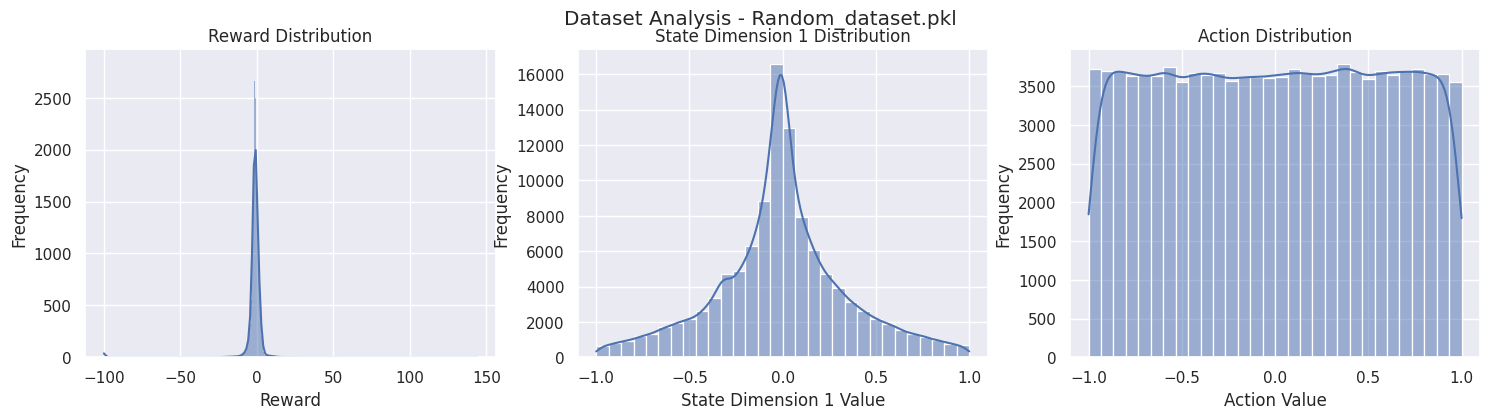


Expert_dataset.pkl - Dataset Analysis:
Number of entries: 126000


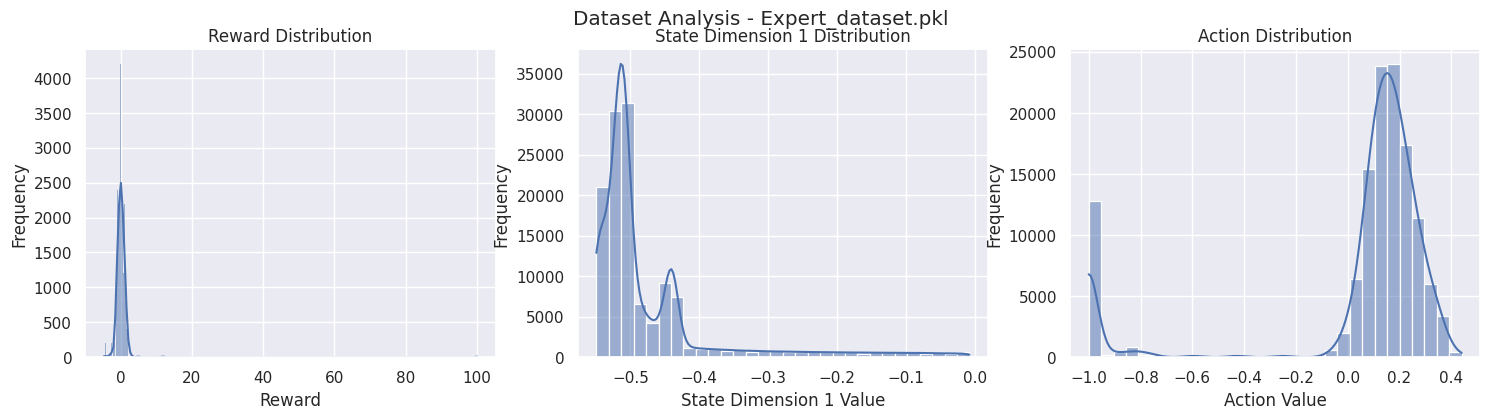


Mixed_dataset.pkl - Dataset Analysis:
Number of entries: 113005


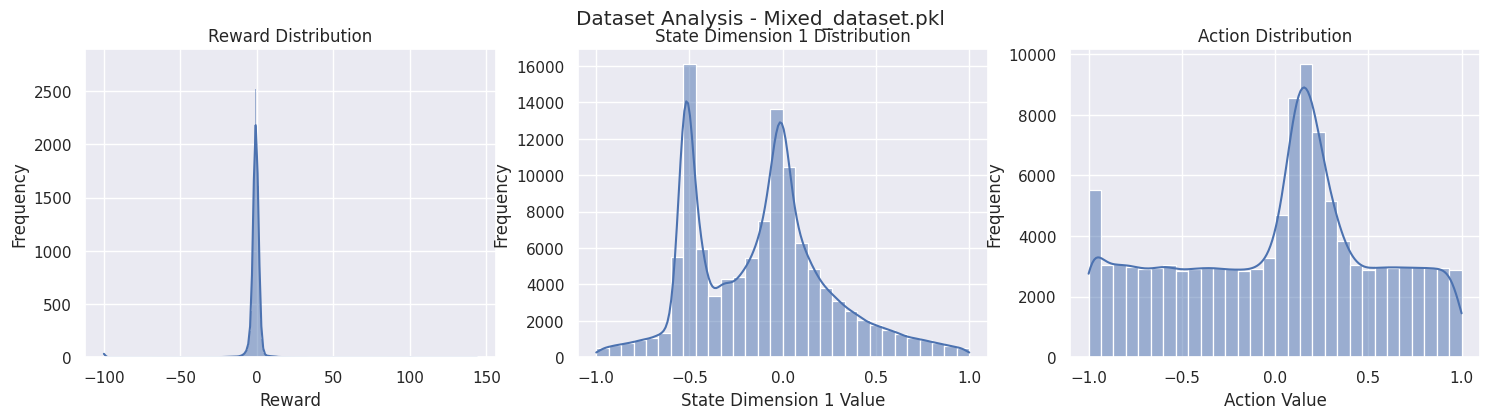


Noisy_dataset.pkl - Dataset Analysis:
Number of entries: 140199


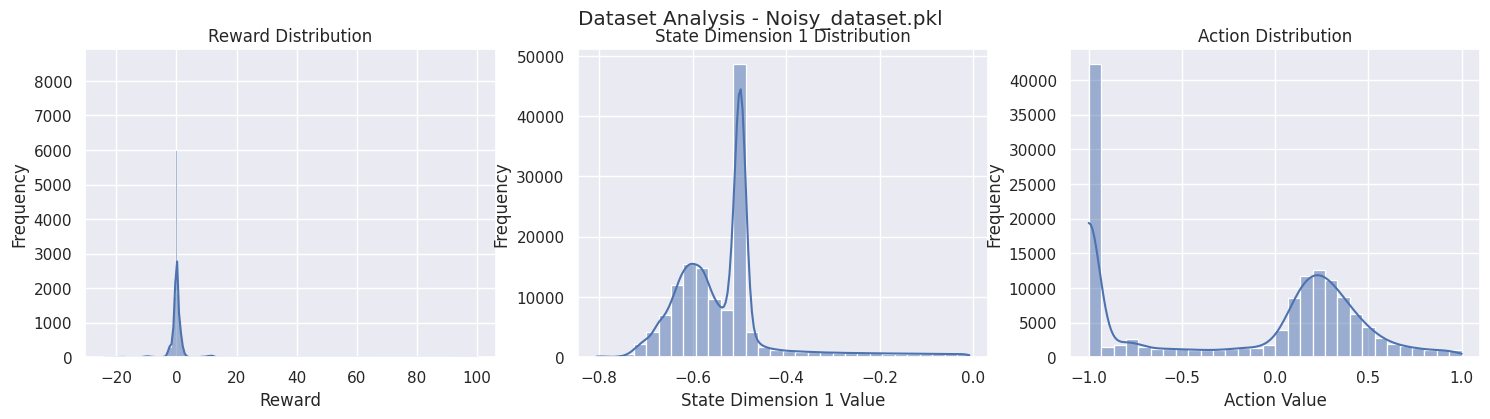


Replay_dataset.pkl - Dataset Analysis:
Number of entries: 100000


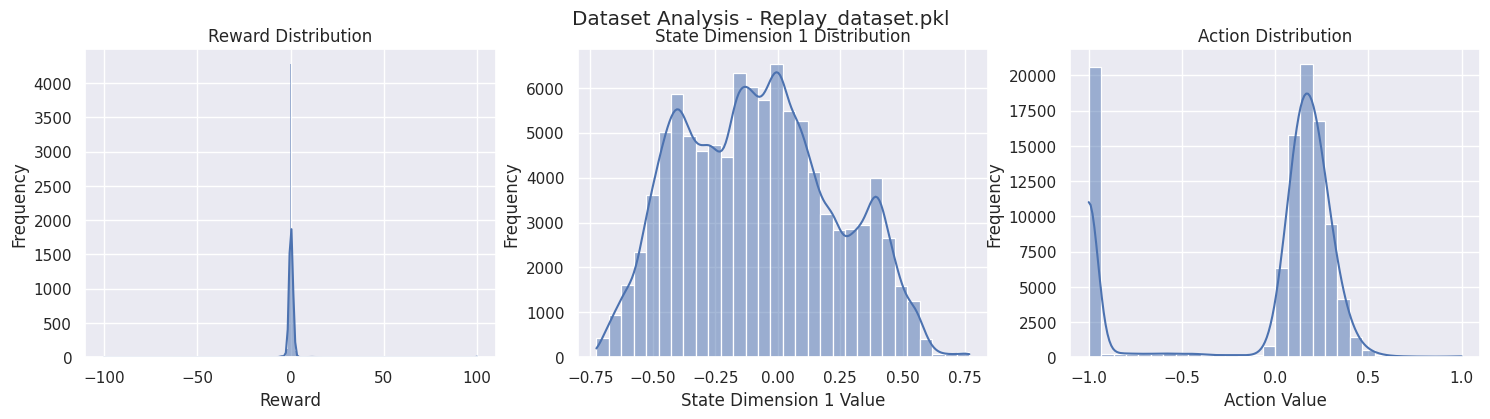

In [29]:
# Exploratory Data Analysis
for name, dataset in datasets.items():
    print(f"\n{name} - Dataset Analysis:")
    print(f"Number of entries: {len(dataset)}")

    # Convert dataset to DataFrame for easier analysis
    df = pd.DataFrame(dataset, columns=['state', 'action', 'reward', 'next_state', 'done'])

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Dataset Analysis - {name}')

    # Reward Distribution
    sns.histplot(df['reward'], kde=True, ax=axes[0])
    axes[0].set_title('Reward Distribution')
    axes[0].set_xlabel('Reward')
    axes[0].set_ylabel('Frequency')

    # State Distribution (example for the first state dimension)
    sns.histplot(df['state'].apply(lambda x: x[0]), bins=30, kde=True, ax=axes[1])
    axes[1].set_title('State Dimension 1 Distribution')
    axes[1].set_xlabel('State Dimension 1 Value')
    axes[1].set_ylabel('Frequency')

    # Action Distribution (assuming single-dimensional action)
    sns.histplot(df['action'].apply(lambda x: x[0]), bins=30, kde=True, ax=axes[2])
    axes[2].set_title('Action Distribution')
    axes[2].set_xlabel('Action Value')
    axes[2].set_ylabel('Frequency')

    plt.show()

**Random Dataset**
*   *Reward Distribution:* The rewards are mostly concentrated around 0, with some outliers. This indicates that the random policy mostly leads to neither very good nor very bad outcomes, as expected with random actions.
*   *State Dimension 1 Distribution:* The distribution of the first state dimension appears to be normally distributed around a center value, which suggests that the random actions lead to a variety of states without any particular direction.
*   *Action Distribution:* Actions are uniformly distributed across the range, consistent with the random sampling of actions.

**Expert Dataset**
*   *Reward Distribution:* The rewards are sharply peaked around 0, indicating that the expert policy consistently achieves moderate outcomes.
*   *State Dimension 1 Distribution:* The state values have a multimodal distribution, which could suggest the expert policy visits certain states more frequently due to the policy's effectiveness.
*   *Action Distribution:* The actions have a bimodal distribution, showing preference for specific actions, which is typical for a trained policy that has learned to prefer certain actions to maximize rewards.

**Mixed Dataset**
*   *Reward Distribution:* Similar to the random dataset, the rewards are centered around 0 but with a slightly broader spread, reflecting the mixture of random and expert data.
*   *State Dimension 1 Distribution:* The state values have a clear peak but also show a wider spread, which indicates a mix of randomness with some structure from the expert data.
*   *Action Distribution:* The action values show a multimodal distribution, suggesting some structure from the expert policy but less pronounced due to the inclusion of random data.

**Noisy Dataset**
*   *Reward Distribution:* The rewards have a broader distribution than the expert dataset, with a clear peak around 0. The width of the distribution indicates that the introduction of noise leads to more varied outcomes.
*   *State Dimension 1 Distribution:* This distribution is less peaked and more spread out than in the expert dataset, which shows the effect of noise introducing more variability in state visitation.
*   *Action Distribution:* There is a clear preference for certain actions, but with wider tails than in the expert dataset, indicating that the noise has introduced some randomness into the action selection.

**Replay Dataset**
*   *Reward Distribution:* The rewards are centered around 0, with a narrow peak, indicating consistent performance, likely because the dataset is generated from a replay of the expert policy.
*   *State Dimension 1 Distribution:* The distribution is more varied than in the expert dataset, suggesting that over the course of many timesteps, the replay captures a wide range of states.
*   *Action Distribution:* The action values are sharply peaked, indicating a strong preference for certain actions, as expected from a replay of an expert policy.


**General Observations:**

The expert dataset shows the characteristics of a trained policy with more structured and less random patterns.
The random dataset, as expected, shows a uniform distribution of actions and no particular pattern in state visits, which is typical for an untrained, exploratory policy.
The mixed dataset reflects a combination of the expert and random datasets, as evidenced by the intermediate structure in its distributions.
The noisy dataset shows how adding randomness to an expert policy can introduce variability into both state visitations and action selections.
The replay dataset captures the behavior of the expert policy over a longer horizon, leading to a wide variety of visited states but consistent action preferences.

These analyses provide valuable insights into the quality and characteristics of each dataset. When training the IQL models, these insights will help in understanding how the models may learn and generalize from each type of data.